# Setup and preprocessing

## Load CSV to dataframe

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [2]:
from tqdm import tqdm
from PIL import UnidentifiedImageError
import ast

In [3]:
GENRE_NAMES = ["action", "adventure", "animation", "biography", "comedy", "crime", "drama", "family", "fantasy", "film-noir", "history", "horror", "music", "musical", "mystery", "romance", "scifi", "sport", "thriller", "war", "western"]

In [4]:
path_ls = [f'../raw_data/500_points/{genre_name}.csv' for genre_name in GENRE_NAMES]
df = pd.concat(
    map(pd.read_csv, path_ls), ignore_index=True)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')].drop_duplicates().reset_index(drop=True)

In [5]:
df.shape

(4237, 5)

In [6]:
df

,movie,imdb_id,genre,plot,image_url
0,Ramayana: The Legend of Prince Rama,tt0259534,"['Animation', ' Action', ' Adventure']","The fantastic story of Rama, a young prince wh...",http://img.omdbapi.com/?i=tt0259534&h=600&apik...
1,The Dark Knight,tt0468569,"['Action', ' Crime', ' Drama']",Set within a year after the events of Batman B...,http://img.omdbapi.com/?i=tt0468569&h=600&apik...
2,The Lord of the Rings: The Return of the King,tt0167260,"['Action', ' Adventure', ' Drama']",The final confrontation between the forces of ...,http://img.omdbapi.com/?i=tt0167260&h=600&apik...
3,Spider-Man: Across the Spider-Verse,tt9362722,"['Animation', ' Action', ' Adventure']",Miles Morales returns for the next chapter of ...,http://img.omdbapi.com/?i=tt9362722&h=600&apik...
4,The Message,tt0075143,"['Action', ' Adventure', ' Biography']","The story of prophet ""Muhammad"" and the delive...",http://img.omdbapi.com/?i=tt0075143&h=600&apik...
...,...,...,...,...,...
4232,Bad Girls,tt0109198,"['Action', ' Adventure', ' Drama']",When saloon prostitute Cody Zamora rescues her...,http://img.omdbapi.com/?i=tt0109198&h=600&apik...
4233,Renegade,tt0276830,"['Adventure', ' Fantasy', ' Western']",Alledged wayward adolescent Louisiana gentlema...,http://img.omdbapi.com/?i=tt0276830&h=600&apik...
4234,Wild Wild West,tt0120891,"['Action', ' Comedy', ' Sci-Fi']",Jim West is a guns-a-blazing former Civil War ...,http://img.omdbapi.com/?i=tt0120891&h=600&apik...
4235,The Ridiculous 6,tt2479478,"['Action', ' Adventure', ' Comedy']","A white man, Tommy, raised by Indians is appro...",http://img.omdbapi.com/?i=tt2479478&h=600&apik...


## Image to array

In [8]:
# resize all images to 350x350
# convert images to arrays (ignore corrupted images)
width, height = 350, 350
image_array = []
unidentified_count = 0
not_found_count = 0
for i in tqdm(range(df.shape[0])):
    try:
        image_path = f"../raw_data/posters/all/{df['imdb_id'][i]}.jpg"
        img = image.load_img(image_path, target_size=(width, height, 3))
        input_arr = image.img_to_array(img)
        input_arr = input_arr/255.0
        image_array.append([df['imdb_id'][i], input_arr])
    except UnidentifiedImageError as e1:
        unidentified_count += 1
        pass
    except FileNotFoundError as e2:
        not_found_count += 1
        pass
print(f"{unidentified_count} files were unidentified and {not_found_count} files were not found")
img_array_df = pd.DataFrame(image_array, columns=["imdb_id", "image_array"])

100%|██████████| 4237/4237 [00:13<00:00, 305.40it/s]


294 files were unidentified and 0 files were not found


In [9]:
# join image_array_df and df on imdb_id (to delete imdb_id with corrupted images)
raw_genre_img_df = df.merge(img_array_df, on="imdb_id", how="right").drop(columns='image_url')

In [10]:
raw_genre_img_df = raw_genre_img_df.dropna().reset_index(drop=True)
raw_genre_img_df = raw_genre_img_df.head(80)

In [11]:
raw_genre_img_df["image_array"] = np.array(raw_genre_img_df["image_array"])
raw_genre_img_df["image_array"] = raw_genre_img_df["image_array"].apply(np.ravel)

In [12]:
raw_genre_img_df["image_array"] = (raw_genre_img_df["image_array"]
    .apply(lambda x: np.reshape(x, (350, 350, 3)))
    )

In [13]:
raw_genre_img_df.head(1)

,movie,imdb_id,genre,plot,image_array
0,Ramayana: The Legend of Prince Rama,tt0259534,"['Animation', ' Action', ' Adventure']","The fantastic story of Rama, a young prince wh...","[[[0.654902, 0.5686275, 0.40784314], [0.819607..."


In [14]:
type(raw_genre_img_df["image_array"][0])

numpy.ndarray

## Hot encoding genres (converting to binary columns)

In [15]:
raw_genre_img_df["genre"] = (
    raw_genre_img_df["genre"]
    .apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    .apply(lambda x: [genre.strip().lower() for genre in x])
    )
raw_genre_img_df["genre"].head(1)

0    [animation, action, adventure]
Name: genre, dtype: object

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(raw_genre_img_df["genre"])

# transform target variable
y = multilabel_binarizer.transform(raw_genre_img_df["genre"])
genre_names = multilabel_binarizer.classes_

# Adding binary columns to main df
for i in range(len(genre_names)):
    raw_genre_img_df[f"{genre_names[i]}"] = y[:,i]

raw_genre_img_df.head(4)

,movie,imdb_id,genre,plot,image_array,action,adventure,animation,biography,comedy,crime,drama,fantasy,mystery,romance,sci-fi,sport,thriller,war,western
0,Ramayana: The Legend of Prince Rama,tt0259534,"[animation, action, adventure]","The fantastic story of Rama, a young prince wh...","[[[0.654902, 0.5686275, 0.40784314], [0.819607...",1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,The Dark Knight,tt0468569,"[action, crime, drama]",Set within a year after the events of Batman B...,"[[[0.16470589, 0.3019608, 0.4509804], [0.16078...",1,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,The Lord of the Rings: The Return of the King,tt0167260,"[action, adventure, drama]",The final confrontation between the forces of ...,"[[[0.54509807, 0.4117647, 0.23529412], [0.5490...",1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Spider-Man: Across the Spider-Verse,tt9362722,"[animation, action, adventure]",Miles Morales returns for the next chapter of ...,"[[[0.49019608, 0.10980392, 0.5137255], [0.4901...",1,1,1,0,0,0,0,0,0,0,0,0,0,0,0


## Prepare train and val dataset

In [17]:
from pathlib import Path
from mlops.params import *
from mlops.ml_logic.data import get_data_with_cache, clean_data, image_data, load_data_to_bq

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X = raw_genre_img_df["image_array"].values
y = raw_genre_img_df.drop(['movie', 'imdb_id', 'genre', 'plot', 'image_array'],axis=1)
X = np.array(list(X))
y = y.to_numpy()
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1)

In [22]:
y.dtype

dtype('int64')

In [23]:
from mlops.ml_logic.registry import load_model, save_results, save_model
from mlops.ml_logic.model import initialize_model, compile_model, train_model


Loading TensorFlow...

✅ TensorFlow loaded (0.0s)


In [24]:
model = initialize_model(input_shape=X_train[0].shape, output_shape=y.shape[1])

In [25]:
model = compile_model(model)

✅ Model compiled


In [26]:
model, history = train_model(
    model, X_train, y_train, X_test, y_test
)


Training model...
Epoch 1/5


2023-08-16 20:49:19.379685: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 6s 1s/step - loss: 1.0232 - accuracy: 0.0556 - val_loss: 0.6831 - val_accuracy: 0.0000e+00
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 0.8743 - accuracy: 0.0833 - val_loss: 0.6248 - val_accuracy: 0.1250
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 0.8418 - accuracy: 0.0694 - val_loss: 0.7317 - val_accuracy: 0.0000e+00
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 0.8162 - accuracy: 0.0278 - val_loss: 1.2470 - val_accuracy: 0.0000e+00
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 0.7422 - accuracy: 0.0694 - val_loss: 2.0799 - val_accuracy: 0.0000e+00
✅ Model trained on 72 rows with accuracy of: 0.07


In [19]:
y_train[0].shape

(15,)

# Deep learning Model

## Prepare the model

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

In [21]:
model = Sequential()
model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=X_train[0].shape))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))


model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(y.shape[1],activation='sigmoid'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 348, 348, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 348, 348, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 174, 174, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 174, 174, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 32)      4640      
                                                                 
 batch_normalization_1 (Batc  (None, 172, 172, 32)     1

## Compile, fit, cross validate

In [29]:
import matplotlib.pyplot as plt

In [24]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [25]:
history = model.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test))

Epoch 1/5


2023-08-13 02:07:32.316181: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 6s 1s/step - loss: 1.0377 - accuracy: 0.0556 - val_loss: 0.9139 - val_accuracy: 0.0000e+00
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 0.8722 - accuracy: 0.0278 - val_loss: 0.6805 - val_accuracy: 0.0000e+00
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 0.8469 - accuracy: 0.0278 - val_loss: 0.5869 - val_accuracy: 0.1250
Epoch 4/5
3/3 [==============================] - 4s 1s/step - loss: 0.8125 - accuracy: 0.0833 - val_loss: 0.5893 - val_accuracy: 0.0000e+00
Epoch 5/5
3/3 [==============================] - 4s 1s/step - loss: 0.7747 - accuracy: 0.0278 - val_loss: 0.6764 - val_accuracy: 0.0000e+00


In [25]:
history.history['accuracy']

[0.10682074725627899,
 0.20800450444221497,
 0.23534385859966278,
 0.2652198374271393,
 0.2779030501842499]

In [20]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

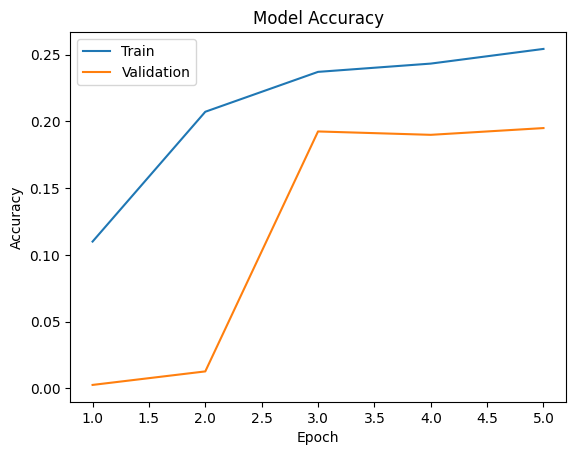

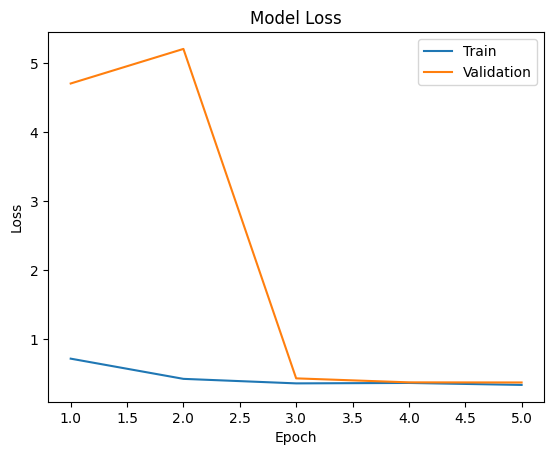

In [21]:
plotLearningCurve(history,5)

# Apply model to predict input poster genre

In [ ]:
from mlops.params import *

<class 'numpy.ndarray'>
1/1 [==============================] - 0s 31ms/step
[[2.1825334e-02 9.9728751e-01 9.9999988e-01 3.5409120e-04 2.7683243e-01
  1.1241399e-03 1.5860708e-01 7.9825275e-02 6.8734840e-02 3.9847866e-01
  2.6481962e-01 8.3713335e-01 1.4701756e-02 9.8336166e-01 9.2390925e-01]]
The model predicts:['animation' 'adventure' 'musical']
Actual Genre: 
['action', 'adventure', 'sci-fi']


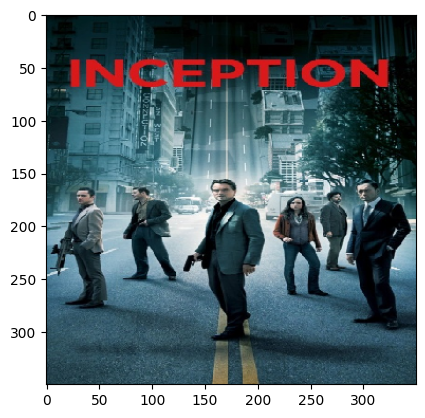

In [35]:
ind = 5
sample_id = raw_genre_img_df["imdb_id"][ind]
img = image.load_img(f'../raw_data/posters/all/{sample_id}.jpg',target_size=(width,height,3))
plt.imshow(img)
img = image.img_to_array(img)
img = img/255.0
img = img.reshape(1,width,height,3)
print(type(img))
classes = np.array(GENRE_NAMES)
y_pred = model.predict(img)
print(y_pred)
top3=np.argsort(y_pred[0])[:-4:-1]

print(f"The model predicts:{classes[top3[0:4]]}")

print("Actual Genre: ")
print(raw_genre_img_df["genre"][ind])

In [34]:
raw_genre_img_df.columns[5:]

Index(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'drama', 'fantasy', 'mystery', 'romance', 'sci-fi', 'sport', 'thriller',
       'war', 'western'],
      dtype='object')